## Integrate MERFISH experiments after QC filtering

In [1]:
import scanpy as sc
import scvi
from tqdm.notebook import tqdm
import os
import numpy as np
import pandas as pd
from scvi.model.utils import mde
import matplotlib.pyplot as plt
import pickle
import glob

c:\Users\amonell\anaconda3_2\envs\scvi\lib\site-packages\scvi\_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
c:\Users\amonell\anaconda3_2\envs\scvi\lib\site-packages\scvi\_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
sc.set_figure_params(figsize=(4, 4))

Add the paths to all folders for experiments to be integrated

In [3]:
input_folders = glob.glob('D:/amonell/merscope_final/SI*')

In [15]:
output_folder = r'D:/amonell/merscope_final/analysis/final'

Run scvi integration

In [6]:
for path_adata in input_folders:
    rolls = glob.glob(os.path.join(path_adata, 'adatas', '05_unrolled*roll_roll*.h5ad'))
    for roll in rolls:
        print(path_adata)
        print(roll)

D:/amonell/merscope_final\SI-Ctrl-L-RAR-R-dist-1-VS120-NP_Beta8
D:/amonell/merscope_final\SI-Ctrl-L-RAR-R-dist-1-VS120-NP_Beta8\adatas\05_unrolled_roll_roll1.h5ad
D:/amonell/merscope_final\SI-Ctrl-L-RAR-R-dist-1-VS120-NP_Beta8
D:/amonell/merscope_final\SI-Ctrl-L-RAR-R-dist-1-VS120-NP_Beta8\adatas\05_unrolled_roll_roll2.h5ad
D:/amonell/merscope_final\SI-Ctrl-L-RARi-R-prox2-VS120-NP_VMSC00201
D:/amonell/merscope_final\SI-Ctrl-L-RARi-R-prox2-VS120-NP_VMSC00201\adatas\05_unrolled_roll_roll1.h5ad
D:/amonell/merscope_final\SI-Ctrl-L-RARi-R-prox2-VS120-NP_VMSC00201
D:/amonell/merscope_final\SI-Ctrl-L-RARi-R-prox2-VS120-NP_VMSC00201\adatas\05_unrolled_roll_roll2.h5ad
D:/amonell/merscope_final\SI-RARi-DMSO-12-20-22-2-VS120-NP_Beta10
D:/amonell/merscope_final\SI-RARi-DMSO-12-20-22-2-VS120-NP_Beta10\adatas\05_unrolled_roll_roll1.h5ad
D:/amonell/merscope_final\SI-RARi-DMSO-12-20-22-2-VS120-NP_Beta10
D:/amonell/merscope_final\SI-RARi-DMSO-12-20-22-2-VS120-NP_Beta10\adatas\05_unrolled_roll_roll2.h5a

In [9]:
adata_list = []
for path_adata in input_folders:
    rolls_ = glob.glob(os.path.join(path_adata, 'adatas', '05_unrolled*roll_roll*.h5ad'))
    for roll in rolls_:
        experiment = sc.read(roll)
        experiment.obs['batch'] = os.path.basename(path_adata)+ f'_{experiment.obs.roll.values[0]}'
        adata_list.append(experiment.copy())

concatenated = sc.concat(adata_list)

concatenated.obs_names_make_unique()
concatenated.layers['counts'] = concatenated.X
scvi.model.SCVI.setup_anndata(concatenated, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(concatenated, n_layers=2, n_latent=30, gene_likelihood="nb")
vae.train()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 3/3: 100%|██████████| 3/3 [13:10<00:00, 263.13s/it, v_num=1, train_loss_step=190, train_loss_epoch=194]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [13:10<00:00, 263.53s/it, v_num=1, train_loss_step=190, train_loss_epoch=194]


Use integration to calculate new clustering and neighbors

In [10]:
concatenated.obsm["X_scVI"] = vae.get_latent_representation()

In [11]:
sc.pp.neighbors(concatenated, use_rep="X_scVI")


c:\Users\amonell\anaconda3_2\envs\scvi\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\amonell\anaconda3_2\envs\scvi\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\amonell\anaconda3_2\envs\scvi\lib\site-packages\umap\distances.py:1086: Num

Use MDE as new visualization. Can sometimes give extreme outlier values so I put some filters on at 8 units in all directions

In [12]:
concatenated.obsm["X_mde"] = mde(concatenated.obsm["X_scVI"])

In [13]:
concatenated.obs['new_batch'] = concatenated.obs.batch.values

In [14]:
xcoords=concatenated.obsm["X_mde"][:, 0]
ycoords=concatenated.obsm["X_mde"][:, 1]
category_names = concatenated.obs.new_batch.values

In [16]:
sc.tl.leiden(concatenated)

In [17]:
os.mkdir(output_folder)

In [29]:
concatenated.write(os.path.join(output_folder, 'concatenated_integrated.h5ad'))

c:\Users\amonell\anaconda3_2\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


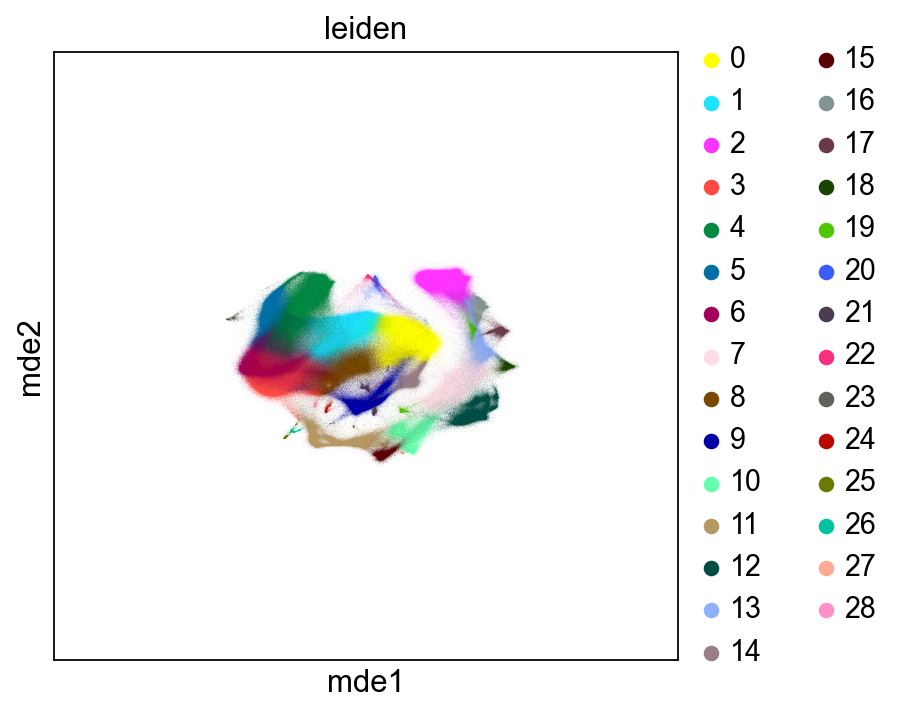

In [28]:
sc.set_figure_params(figsize=(5, 5))
sc.pl.embedding(concatenated, basis='mde', color=['leiden'])

## Save our SCVI VAE

In [20]:
import pickle

# File path where you want to save the object
file_path = os.path.join(output_folder, "vae_object.pkl")

# Dump the object to the file
with open(file_path, "wb") as file:
    pickle.dump(vae, file)


## Subcluster data

In [ ]:
def get_celltype(celltype, ad_sp):
    ctype = ad_sp[ad_sp.obs.leiden.isin([celltype])]
    sc.pp.neighbors(ctype, use_rep='X_scVI')
    sc.tl.leiden(ctype, resolution= 0.5)
    sc.tl.umap(ctype)
    return ctype
def reunite_with_ad(ad_sp, subset_ad, celltype):
    new_labels  = []
    subclusters = ad_sp.obs.Sub_leiden.values
    clusters = ad_sp.obs.leiden.values
    idex = ad_sp.obs.index.values
    for i in tqdm(range(len(subclusters))):
        if clusters[i] == celltype:
            new_labels.append(subset_ad.obs.loc[idex[i], :].leiden)
        else:
            new_labels.append(subclusters[i])
    ad_sp.obs.Sub_leiden = new_labels
    return ad_sp


In [ ]:
ad_sp = sc.read(os.path.join(output_folder, 'concatenated_integrated.h5ad'))
ad_sp.obs['Sub_leiden'] = ad_sp.obs['leiden']

In [ ]:
lts = ad_sp.obs.leiden.cat.categories
for leiden_to_subset in lts:
    mac = get_celltype(leiden_to_subset, ad_sp)
    sc.pl.embedding(mac, basis='mde', color=['leiden'], vmax=1, size=0.1)
    mac.obs['leiden'] = [leiden_to_subset + '_' + i for i in mac.obs.leiden]
    ad_sp = reunite_with_ad(ad_sp, mac, leiden_to_subset)
    sc.pl.embedding(ad_sp, basis='mde', color=['Sub_leiden'])

In [ ]:
ad_sp.write(os.path.join(output_folder, 'integrated_clustered.h5ad'))